In [6]:
import pandas as pd

# 加载数据
data = pd.read_csv('simulated_transaction_2024.csv')

# 删除 Date, Timestamp, Account No, Balance, Amount 中任一为空的行
data.dropna(subset=['Date', 'Timestamp', 'Account No', 'Balance', 'Amount'], inplace=True)

# 删除 Third Party Account No 和 Third Party Name 同时为空的行
data.dropna(subset=['Third Party Account No', 'Third Party Name'], how='all', inplace=True)

# 保存处理后的数据
data.to_csv('cleaned_simulated_transaction_2024.csv', index=False)

print('Data cleaned and saved to: cleaned_simulated_transaction_2024.csv')


Data cleaned and saved to: cleaned_simulated_transaction_2024.csv


In [7]:
import pandas as pd

# 加载数据
data = pd.read_csv('cleaned_simulated_transaction_2024.csv', dayfirst=True)

# 解析日期列，并确保格式正确
# dayfirst=True 确保按照 "日/月/年" 格式解析日期
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y', dayfirst=True)

# 定义一个函数来将月份转换为季度
def month_to_quarter(month):
    # 通过月份来确定季度
    return (month - 1) // 3 + 1

# 创建新的列 'quarter' 基于 'Date' 列的月份
data['quarter'] = data['Date'].dt.month.apply(month_to_quarter)

# 保存修改后的数据
data.to_csv('cleaned_simulated_transaction_2024_with_quarters.csv', index=False)

print('Updated data saved to: cleaned_simulated_transaction_2024_with_quarters.csv')


Updated data saved to: cleaned_simulated_transaction_2024_with_quarters.csv


In [12]:
import pandas as pd

# 读取数据
data = pd.read_csv('cleaned_simulated_transaction_2024_with_quarters.csv')
data['Date'] = pd.to_datetime(data['Date'])

# 为了计算R，我们需要定义每个季度的最后一天
quarter_ends = {
    1: pd.Timestamp('2023-04-1'),
    2: pd.Timestamp('2023-07-1'),
    3: pd.Timestamp('2023-10-1'),
    4: pd.Timestamp('2023-12-7')
}

# 为每个季度创建RFM数据集
rfm_data_list = []

for quarter in range(1, 5):
    # 选择当前季度的数据
    quarter_data = data[data['quarter'] == quarter]

    # R: 最近一次消费的日期
    r = quarter_data.groupby('Account No')['Date'].max().reset_index()
    r['R'] = (quarter_ends[quarter] - r['Date']).dt.days
    r = r.drop(columns='Date')  # 移除Date列
    
    # F: 交易频率
    f = quarter_data.groupby('Account No').size().reset_index(name='F')

    # M: 金额总和（使用金额的绝对值）
    m = quarter_data.groupby('Account No')['Amount'].apply(lambda x: x.abs().sum()).reset_index(name='M')

    # 合并RFM，并加上季度标记
    rfm = pd.merge(pd.merge(r, f, on='Account No'), m, on='Account No')
    rfm['quarter'] = quarter

    # 添加到列表
    rfm_data_list.append(rfm)

# 合并所有季度的数据
rfm_data = pd.concat(rfm_data_list, ignore_index=True)

# 输出结果到CSV文件
rfm_data.to_csv('rfm_data.csv', index=False)


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

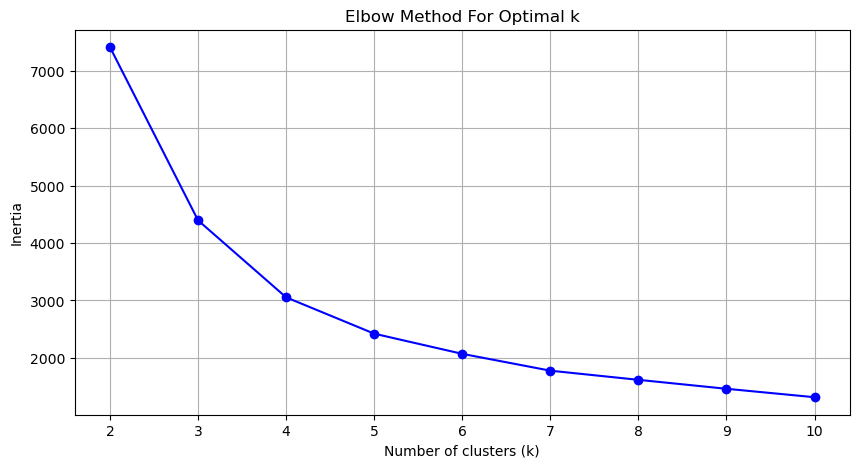

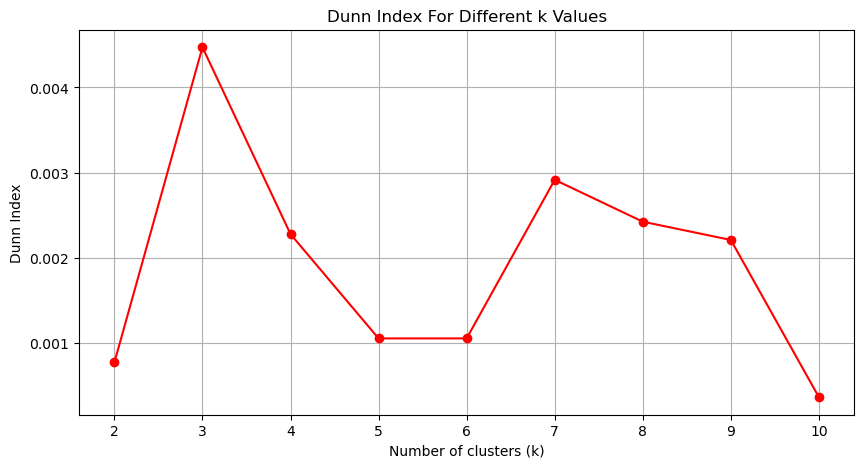

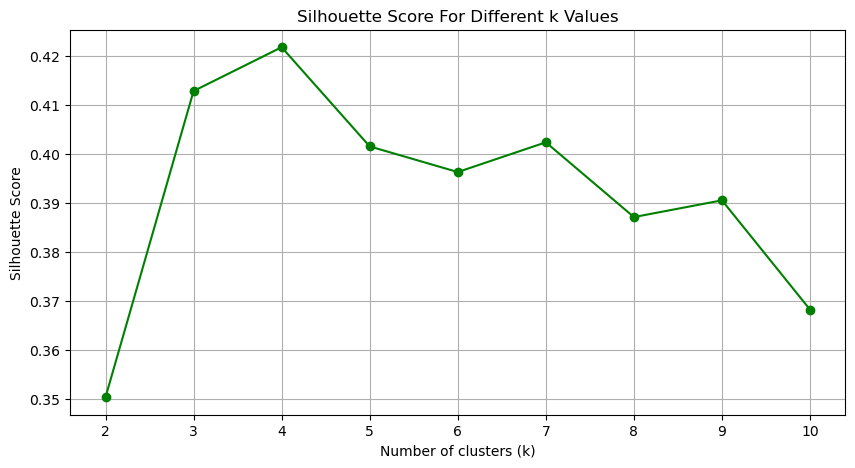

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, silhouette_score
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist

def calculate_dunn_index(X, labels, clusters):
    """计算Dunn指数，用于评估聚类的紧凑性和分离性。"""
    distances = pairwise_distances(X, metric='euclidean')
    diameters = np.zeros(clusters)
    separations = np.full((clusters, clusters), np.inf)
    
    for i in range(clusters):
        points_i = X[labels == i]
        if points_i.size:
            diameters[i] = np.max(cdist(points_i, points_i, 'euclidean'))
        for j in range(i+1, clusters):
            points_j = X[labels == j]
            if points_j.size:
                sep = np.min(cdist(points_i, points_j, 'euclidean'))
                separations[i, j] = sep
                separations[j, i] = sep
    
    return np.min(separations) / np.max(diameters)

# 载入数据
df = pd.read_csv('rfm_data.csv')

# 选择特征列
X = df[['R', 'F', 'M']].values

# 标准化数据
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 肘部法则、Dunn指数和轮廓系数计算
inertia = []
dunn_indices = []
silhouette_scores = []
K = range(2, 11)  # 尝试不同的k值从2到10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    
    labels = kmeans.labels_
    dunn_index = calculate_dunn_index(X_scaled, labels, k)
    dunn_indices.append(dunn_index)
    
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)

# 绘制肘部图
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.savefig('elbow_scores.png')
plt.show()

# 绘制Dunn指数图
plt.figure(figsize=(10, 5))
plt.plot(K, dunn_indices, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Dunn Index')
plt.title('Dunn Index For Different k Values')
plt.grid(True)
plt.show()

# 绘制轮廓系数图
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Different k Values')
plt.grid(True)
plt.savefig('silhouette_scores.png')
plt.show()


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Transient\AppData\Local\Temp\ipykernel_12780\3489345298.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_current_quarter['Cluster'] = kmeans.fit_predict(features)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: 

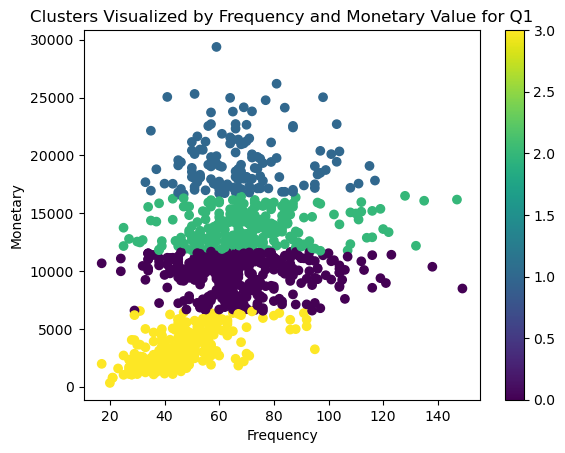

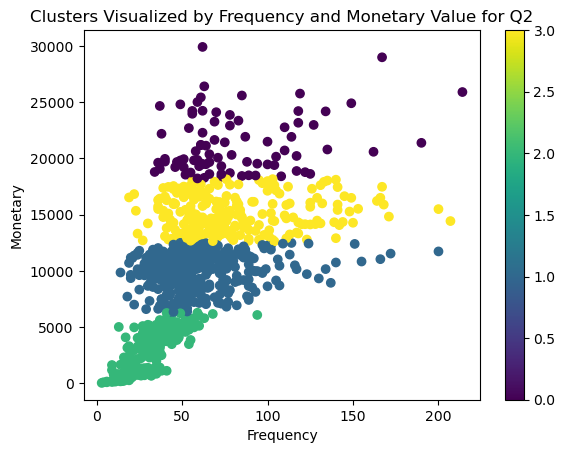

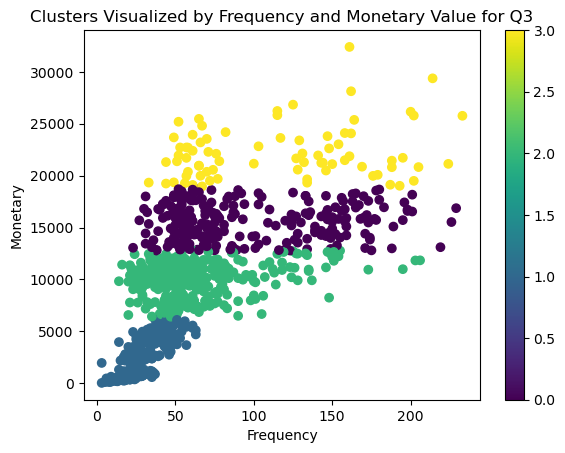

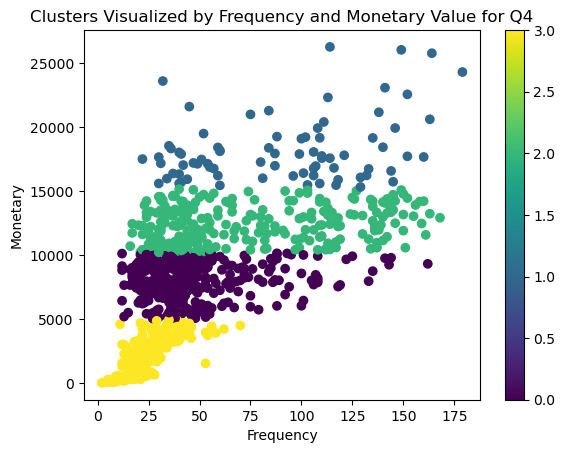

In [21]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 载入数据
file_path = 'rfm_data.csv'  # 请将此路径替换为你的文件路径
data = pd.read_csv(file_path)

# 准备一个空的DataFrame来收集所有季度的数据
all_quarters_data = pd.DataFrame()

# 处理四个季度的数据
for quarter in range(1, 5):
    # 筛选当前季度的数据
    data_current_quarter = data[data['quarter'] == quarter]

    # 使用'R', 'F', 'M'列进行聚类
    features = data_current_quarter[['R', 'F', 'M']]

    # 创建k-means模型，k设为4
    kmeans = KMeans(n_clusters=4, random_state=0)
    data_current_quarter['Cluster'] = kmeans.fit_predict(features)

    # 收集聚类结果
    all_quarters_data = pd.concat([all_quarters_data, data_current_quarter], ignore_index=True)

    # 可视化结果（可选）
    plt.figure(quarter)
    plt.scatter(data_current_quarter['F'], data_current_quarter['M'], c=data_current_quarter['Cluster'], cmap='viridis')
    plt.xlabel('Frequency')
    plt.ylabel('Monetary')
    plt.title(f'Clusters Visualized by Frequency and Monetary Value for Q{quarter}')
    plt.colorbar()

# 保存整合后的数据到一个文件
all_quarters_data.to_csv('all_quarters_clustered_data.csv', index=False)

plt.show()


In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 读取数据
data = pd.read_csv('all_quarters_clustered_data.csv')

# 初始化MinMaxScaler
scaler = MinMaxScaler()

# 选择需要归一化的列
columns_to_normalize = ['R', 'F', 'M']

# 对数据进行归一化处理
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

# 保存归一化后的数据到新的CSV文件
data.to_csv('normalized_rfm_data.csv', index=False)

# 输出一些信息以确认过程完成
print("Data has been normalized and saved to 'normalized_rfm_data.csv'.")


Data has been normalized and saved to 'normalized_rfm_data.csv'.


In [14]:
import numpy as np
from scipy.linalg import eig

def ahp(criteria, judgments):
    # 根据判断矩阵计算特征向量和特征值
    eigvals, eigvecs = eig(judgments)
    max_eigval = np.max(eigvals.real)
    max_index = np.argmax(eigvals.real)
    weights = eigvecs[:, max_index].real
    weights = weights / weights.sum()

    # 计算一致性指标
    n = len(criteria)
    CI = (max_eigval - n) / (n - 1)
    RI = [0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45][n-1]
    CR = CI / RI if RI else 0

    return weights, CR

# 准则
criteria = ['R', 'F', 'M']

# 判断矩阵，例子中的数值需要根据实际评估来设定
judgments = np.array([
    [1, 1/3, 5],
    [3, 1, 7],
    [1/5, 1/7, 1]
])

# 计算AHP权重和一致性比率
weights, CR = ahp(criteria, judgments)

print("Weights: ", weights)
print("Consistency Ratio: ", CR)


Weights:  [0.27895457 0.649118   0.07192743]
Consistency Ratio:  0.05593756885588095


In [17]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 载入数据
file_path = 'normalized_rfm_data.csv'  # 请将此路径替换为你的文件路径
data = pd.read_csv(file_path)

# 过滤只关注第一季度的数据
data = data[data['quarter'] == 4]

# 权重，这些应该是与R、F、M相对应的权重
weights = [0.2797, 0.6267, 0.0936]

# 创建一个空的DataFrame来存储结果
results = pd.DataFrame(columns=['Cluster', 'Percent of customer', 'Normalized R', 'Normalized F', 'Normalized M', 'CLV Value'])

# 对每个簇进行循环
for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    percent = (len(cluster_data) / len(data)) * 100
    mean_r = cluster_data['R'].mean()
    mean_f = cluster_data['F'].mean()
    mean_m = cluster_data['M'].mean()
    
    # 计算CLV值
    clv_value = (mean_r * weights[0]) + (mean_f * weights[1]) + (mean_m * weights[2])
    
    # 构建一个新的DataFrame行
    new_row = pd.DataFrame({
        'Cluster': ['c' + str(cluster)],
        'Percent of customer': [percent],
        'Normalized R': [mean_r],
        'Normalized F': [mean_f],
        'Normalized M': [mean_m],
        'CLV Value': [clv_value]
    })
    
    # 使用concat添加到结果DataFrame中
    results = pd.concat([results, new_row], ignore_index=True)

# 将结果按照簇的标签排序
results.sort_values('Cluster', inplace=True)

# 保存结果到CSV
results.to_csv('cluster_summary_Q4.csv', index=False)

# 显示结果
print(results)


  Cluster  Percent of customer  Normalized R  Normalized F  Normalized M  \
0      c0            35.348361      0.176285      0.190401      0.248394   
1      c1             7.991803      0.087413      0.384060      0.562765   
2      c2            27.049180      0.108815      0.314951      0.380439   
3      c3            29.610656      0.306386      0.087104      0.057208   

   CLV Value  
0   0.191881  
1   0.317815  
2   0.263425  
3   0.145639  


C:\Users\Transient\AppData\Local\Temp\ipykernel_12048\3339834442.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


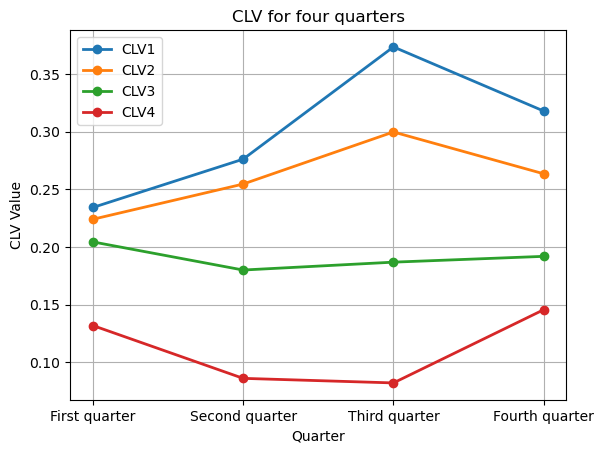

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming that 'CLV_Value.csv' contains the correct data with quarters and CLV ranks
data = pd.read_csv('CLV_Value.csv')

# Creating a color palette
palette = plt.get_cmap('tab10')

# Plotting each line
for i, clv_rank in enumerate(data['CLV Rank']):
    plt.plot(data.columns[1:], data.iloc[i, 1:], marker='o', color=palette(i), linewidth=2, label=clv_rank)

# Adding legend
plt.legend()

# Adding title and labels
plt.title("CLV for four quarters")
plt.xlabel("Quarter")
plt.ylabel("CLV Value")
plt.grid(True)

# Set the x-axis to display each quarter evenly
plt.xticks(range(len(data.columns[1:])), data.columns[1:])

# Save the figure
plt.savefig('CLV_Value_ZSYY.png')

# Show the chart
plt.show()


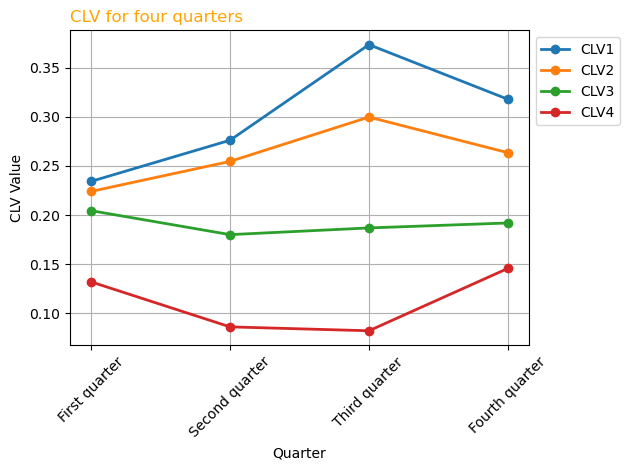

Predicted CLV for CLV1: 0.31237293833333335
Predicted CLV for CLV2: 0.29618762266666665
Predicted CLV for CLV3: 0.26312267233333336
Predicted CLV for CLV4: 0.23109781100000001


D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base

In [21]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 加载数据
def load_data(file_path):
    return pd.read_csv(file_path)

# 定义SARIMA模型并进行预测的函数
def fit_predict_sarima(series, order, seasonal_order):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps=1).predicted_mean
    return forecast.iloc[0]

# 主程序
def main():
    # 加载数据
    data = load_data('CLV_Value.csv')  # 确保文件路径正确

    # 设定模型参数
    order = (0, 1, 0)  # 非季节性差分
    seasonal_order = (0, 1, 0, 4)  # 季节性差分，季节长度为4

    # 预测每个CLV等级
    predictions = {}
    for clv_rank in data['CLV Rank']:
        series = data.loc[data['CLV Rank'] == clv_rank, data.columns[1:]].squeeze()
        prediction = fit_predict_sarima(series, order, seasonal_order)
        predictions[clv_rank] = prediction

    # 打印预测结果
    for clv_rank, pred_value in predictions.items():
        print(f'Predicted CLV for {clv_rank}: {pred_value}')

if __name__ == "__main__":
    main()


Predicted CLV for CLV1: 0.4739659886666666
Predicted CLV for CLV2: 0.41276137700000004
Predicted CLV for CLV3: 0.32815194700000005
Predicted CLV for CLV4: 0.23359087966666664


D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base

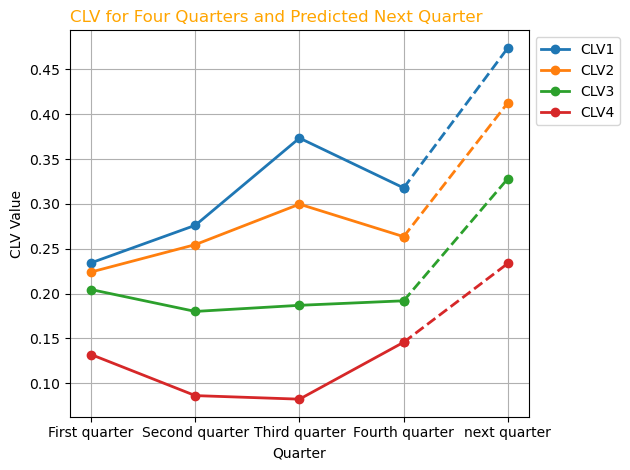

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 加载CSV数据到DataFrame
def load_data(file_path):
    return pd.read_csv(file_path)

# 定义SARIMA模型并进行预测的函数
def fit_predict_sarima(series, order, seasonal_order):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps=1).predicted_mean
    return forecast.iloc[0]

# 绘制四个季度及预测值的函数
def plot_clv(data, predictions):
    palette = plt.get_cmap('tab10')
    quarters = data.columns[1:]  # Existing four quarters
    future_quarter = ['next quarter']  # Renamed predicted quarter

    for i, clv_rank in enumerate(data['CLV Rank']):
        # Plot the first four quarters with a solid line
        series = list(data.iloc[i, 1:5])
        plt.plot(quarters, series, marker='o', color=palette(i), linewidth=2, label=clv_rank)

        # Plot the transition from the fourth quarter to the next with a dashed line
        series_with_prediction = series + [predictions[clv_rank]]
        plt.plot([quarters[-1], future_quarter[0]], series_with_prediction[-2:], marker='o', color=palette(i), linewidth=2, linestyle='--')

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title("CLV for Four Quarters and Predicted Next Quarter", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Quarter")
    plt.ylabel("CLV Value")
    plt.grid(True)
    # Set x-axis labels horizontally
    plt.xticks(range(len(quarters) + 1), quarters.tolist() + future_quarter, rotation=0)
    plt.tight_layout()
    plt.savefig('Prediction.png')
    plt.show()


def main():
    # 加载数据
    data = load_data('CLV_Value.csv')  # 确保文件路径正确

    # 设定模型参数
    order = (0, 1, 0)  # 非季节性差分
    seasonal_order = (0, 1, 0, 4)  # 季节性差分，季节长度为4

    # 预测每个CLV等级的第五季度
    predictions = {}
    for clv_rank in data['CLV Rank']:
        series = data.loc[data['CLV Rank'] == clv_rank, data.columns[1:]].squeeze()
        prediction = fit_predict_sarima(series, order, seasonal_order)
        predictions[clv_rank] = prediction

    # 绘制预测结果和之前的四个季度
    plot_clv(data, predictions)

if __name__ == "__main__":
    main()


In [18]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 加载数据
data = pd.read_csv('rfm_data.csv')

# 选择你提到的R, F, M列并过滤quarter等于1的数据
# 假设数据集中的列名确切地叫做 'R', 'F', 'M' 和 'quarter'。如果不是，请替换为实际的列名。
filtered_data = data[data['quarter'] == 1]
rfm_data = filtered_data[['R', 'F', 'M']]

# 数据标准化
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_data)

# 应用 K-means 聚类
kmeans = KMeans(n_clusters=4, random_state=0)
filtered_data['Cluster'] = kmeans.fit_predict(rfm_normalized)

# 将聚类结果合并回原始数据集
data = data.merge(filtered_data[['R', 'F', 'M', 'Cluster']], on=['R', 'F', 'M'], how='left')

# 保存带有聚类结果的数据集到新的 CSV 文件
data.to_csv('rfm_data_with_clusters.csv', index=False)

print("聚类完成，结果已保存到 'rfm_data_with_clusters.csv'")


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


聚类完成，结果已保存到 'rfm_data_with_clusters.csv'


C:\Users\Transient\AppData\Local\Temp\ipykernel_19732\1508634409.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Cluster'] = kmeans.fit_predict(rfm_normalized)


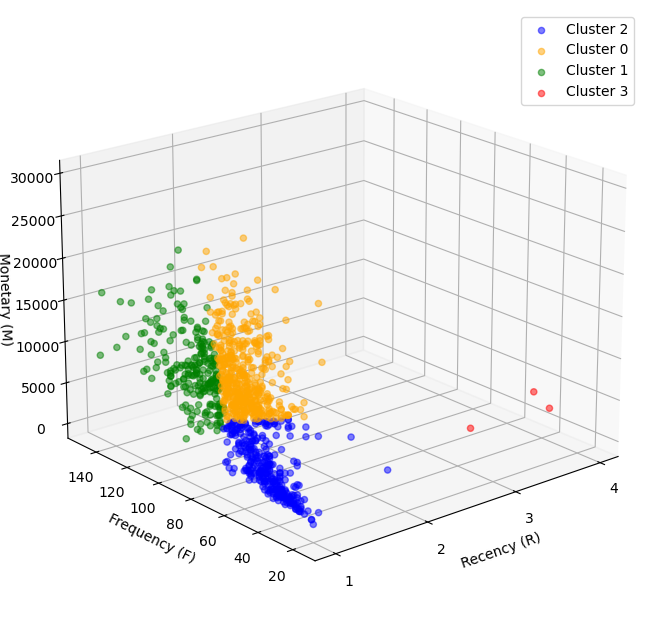

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 载入数据
data = pd.read_csv('rfm_data_with_clusters.csv')

# 过滤数据，仅选择quarter等于1的行
data = data[data['quarter'] == 1]

data['Cluster'] = data['Cluster'].astype(int)

# 创建3D图形的绘图对象
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 设置颜色映射，为每个Cluster分配颜色
colors = {0: 'orange', 1: 'green', 2: 'blue', 3: 'red'}

# 根据R, F, M的范围和间隔分组绘制每个点，调整点的大小为20，并去掉边缘颜色
for cluster in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster]
    ax.scatter(cluster_data['R'], cluster_data['F'], cluster_data['M'], 
               c=colors[cluster], label=f'Cluster {cluster}', s=20, alpha=0.5)

# 设置图例
ax.legend()

# 设置轴标签
ax.set_xlabel('Recency (R)')
ax.set_ylabel('Frequency (F)')
ax.set_zlabel('Monetary (M)')

# 设置轴的间隔，使其更加清晰
ax.set_xticks([i for i in range(1, 5)]) # R的间隔保持为0.5
ax.set_yticks([i for i in range(20, 160, 20)]) # F的间隔保持为20
ax.set_zticks([i for i in range(0, 35000, 5000)]) # M的间隔保持为5000

# 调整视角
ax.view_init(elev=20, azim=230) # 调整视角为从右侧看过去
plt.savefig('K-means-classification-quarter1.png')
# 显示图表
plt.show()
